In [3]:
from __future__ import division
import numpy as np
import math
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.coordinates as coord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
#from kde import weighted_gaussian_kde
from scipy import stats
from astropy.cosmology import FlatLambdaCDM,Planck15
import sys
from time import gmtime, strftime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [4]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import math
from astropy.io import ascii
##Read in the cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Read in the clustering api (powell's code)

In [5]:
import clustering.clustering.projected_correlation_functions as w
import clustering.clustering.randomsEdited as rand
from clustering.clustering.utils import wp_d1d2,wp_dd

## Use Merry's code to generate Random Peas Catalogs

In [6]:
# read in function from Merry's program
#from clustering.clustering.randoms import genrand
from clustering.clustering.randomsEdited import genrand

In [6]:
# read in orignal Peas file
t=Table.read('../codes/MainCatalogues/dr12PeastoPortStarforming.fits',format='fits')
peas=np.array(t)

#Add new array field of comoving distances needed for Corrfunc inputs
cdists = np.array([cosmo.comoving_distance(z).value for z in peas['z']])*cosmo.h
peas = append_fields(peas, 'cdist', cdists)

# append the field and make back into normal array
peas=np.array(peas)

In [6]:
#n=factor times more than peas to create a randoms catalog
n=500

number of randoms: 796000


/data/home/mokyay/Documents/Green-Peas/codes/clustering/clustering/randomsEdited.py:215: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(data['z'], histtype='stepfilled', bins=20, alpha=0.2, color='k', normed=True, label='data \n N=' + str(nd))
/data/home/mokyay/Documents/Green-Peas/codes/clustering/clustering/randomsEdited.py:216: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(randoms['z'], histtype='step', bins=20, alpha=0.5, normed=True, label='randoms\n N=' + str(nr))


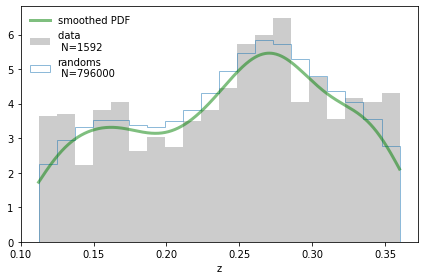

In [7]:
## No selection function for peas, so randomize only in redshift not position!!!! right now running w/ +/- 1deg pos(this is hard coded)
rzpea=genrand(peas,n,cosmo,width=.30, useRaDec = True, scoords='galactic',use_BASS_sens_map=False,plot=True,plot_filename=None, randomize=False)
np.save('../codes/output/rzpeas.npy', rzpea)

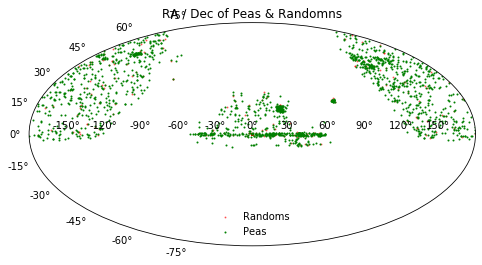

In [8]:
ra = coord.Angle(peas['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(peas['dec']*u.degree)

rar = coord.Angle(rzpea['ra']*u.degree)
rar = rar.wrap_at(180*u.degree)
decr = coord.Angle(rzpea['dec']*u.degree)

##subsample rar decr for plotting....
sm=len(rar)/10
sm=int(sm)

ind = np.random.randint(len(rar), size=sm)
rarsm=rar[ind]
decrsm=decr[ind]
## EDIT 6/30, let's keep it large for now to see what the result will be.
##Note - file needed be QUITE so large, what about making it smaller?
#sm=len(LRGr)/2
#if sm%2 == 1:
#    sm=sm+1
#sm=int(sm)
#ind = np.random.randint(len(LRGr), size=sm)
#LRGrsm=LRGr[ind]
#print(len(LRGr),len(LRGrsm))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")

ax.scatter(rarsm.radian,decrsm.radian,1,color='r',alpha=.5,label='Randoms')
ax.scatter(ra.radian, dec.radian,1,color='g',marker='o',label='Peas')

# blue is non-random default color used, black is randoms (k), reds r, cyan is c, green is g, points is transparent
# marker='o', '+', '*','.', 'x','square' or 's'	Square'diamond'or'd','^','v', '>', '<','pentagram' or 'p','hexagram' or 'h','none'
plt.legend(loc=8, frameon=False)
plt.title('RA / Dec of Peas & Randomns')

plt.savefig('../codes/plots/PeaRand_ra_dec.pdf')

/home/mokyay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/mokyay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


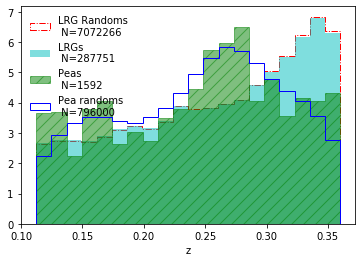

In [129]:
rzpea = np.load('../codes/output/rzpeas.npy')
LRG= Table.read('../codes/MainCategories/LRGzcat.fits')
LRGr=Table.read('../codes/MainCategories/LRGRandzcat.fits')

ndLRG = len(LRG)
nrLRG = len(LRGr)
plt.hist(LRGr['z'], histtype='step', bins=20,alpha=1,color='r',edgecolor='r',ls='-.',weights=None,density=True,\
         label='LRG Randoms \n N='+str(nrLRG))
plt.hist(LRG['z'], histtype='stepfilled', bins=20,alpha=0.5,color='c',  density=True,weights=None,\
         label='LRGs\n N='+str(ndLRG))
plt.xlabel('z')
plt.legend(loc='best', frameon=False)

#plot z distributions
nd = len(peas)
nr = len(rzpea)
plt.hist(peas['z'], histtype='stepfilled', bins=20, hatch='//', alpha=0.5,color='g',edgecolor = 'g', aa=True, weights=None,normed=True,\
         label='Peas \n N='+str(nd))
plt.hist(rzpea['z'], histtype='step', bins=20,alpha=1,color='b',normed=True, ls='-', weights=None,\
         label='Pea randoms\n N='+str(nr))
plt.xlabel('z')
plt.legend(loc='upper left', frameon=False)

plt.savefig('output/zdist_PeasRandomnsLRGrandoms_wnoRADECvariations.pdf')

#plt.savefig('../plots/zdist_PeasRandomns_wnoRADECvariations.pdf')

## Read in LRGs -> Run Auto & Cross Correlations (find best pimax)

In [20]:
## Read in LRG Data
LRG= Table.read('../codes/cat/LRGzcat.fits')
LRGr=Table.read('../codes/cat/LRGRandzcat.fits')

In [122]:
#determine bins and pimax
bins = np.array([.1,.5,1,3,6,8,10,15,20,30,40,50,60,80,100])
pimax = 60

In [22]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjack,wp_xc_Pjack,wp_xc_err_Pjack,cov_xc_Pjack = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjack)
np.save('output/wp_xc_Pjack',wp_xc_Pjack)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjack)
np.save('output/cov_xc_Pjack',cov_xc_Pjack)

2020-10-23 02:31:44


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.748 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.453 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.991 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.372 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.067 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.413 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 701. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.916 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.361 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 752. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.355 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.425 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.374 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.411 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 761. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.360 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 742. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.923 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.336 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 785. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.390 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.422 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.382 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 687. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 49,45,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 49,45,9.  Time taken =   0.807 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.381 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 630. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.780 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.290 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 754. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.966 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.392 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.388 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.997 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.417 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 747. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.986 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.394 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 709. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.855 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.358 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 782. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.410 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.020 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.428 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.418 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 719. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.907 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.371 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.399 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%......

2020-10-23 02:56:49


...100% done. Time taken =  0.415 secs


Read old LRG autocorrelation luminousredgalaxies.ipynb

In [23]:
rp_LRGjack=np.load('output/rp_LRGjack.npy')
wp_p_LRGjack=np.load('output/wp_p_LRGjack.npy')
wp_p_err_LRGjack=np.load('output/wp_p_err_LRGjack.npy')
cov_LRGjack=np.load('output/cov_LRGjack.npy')

Text(0.5, 1.0, 'Cross-Correlation Functions')

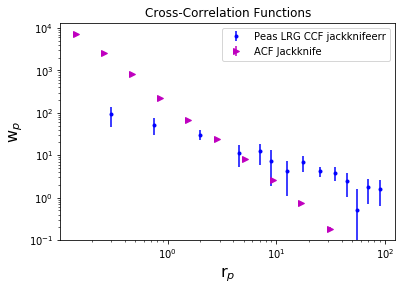

In [24]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_xc_Pjack,wp_xc_Pjack,yerr=wp_xc_err_Pjack,fmt='.',color='b',label='Peas LRG CCF jackknifeerr')
plt.errorbar(rp_LRGjack,wp_p_LRGjack/rp_LRGjack,yerr=wp_p_err_LRGjack/rp_LRGjack,fmt='>',color='m',label='ACF Jackknife')
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions')

In [25]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 10
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi10,wp_xc_Pjackpi10,wp_xc_err_Pjackpi10,cov_xc_Pjackpi10 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi10)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi10)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi10)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi10)

2020-10-23 02:56:49


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   2.000 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.225 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.187 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.241 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.229 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 416. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 446. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.154 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.254 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.184 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.181 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 451. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.206 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 440. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.160 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 466. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.166 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.189 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.061 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.180 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.176 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 35, 11); avg_np = 418. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 57,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 57,52,11.  Time taken =   0.997 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.168 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 374. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.932 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.124 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 10); avg_np = 492. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.171 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.265 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.203 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 443. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.180 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 421. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.181 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 464. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.173 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.173 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.183 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.178 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.190 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 427. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.165 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 448. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.172 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.006 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.322 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.173 secs


2020-10-23 03:22:04


In [26]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 20
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi20,wp_xc_Pjackpi20,wp_xc_err_Pjackpi20,cov_xc_Pjackpi20 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi20)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi20)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi20)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi20)

2020-10-23 03:22:04


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.932 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.240 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.179 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.216 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.178 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.209 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 483. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.188 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 518. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.222 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.222 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.223 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.214 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.236 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 525. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,51,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,51,10.  Time taken =   1.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 512. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 541. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.218 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.238 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.221 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,10.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 34, 10); avg_np = 487. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,52,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,52,10.  Time taken =   0.983 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.208 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 435. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.878 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 520. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.214 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.195 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.262 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 515. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.214 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 489. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 540. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.174 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.254 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.173 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.212 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.180 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.220 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 496. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.190 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 521. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.217 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.225 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,34,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 34, 10); avg_np = 547. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.152 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.230 secs


2020-10-23 03:47:26


In [27]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 30
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi30,wp_xc_Pjackpi30,wp_xc_err_Pjackpi30,cov_xc_Pjackpi30 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi30)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi30)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi30)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi30)

2020-10-23 03:47:26


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.894 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.287 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.143 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.257 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.163 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.252 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 511. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.216 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 548. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.234 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.250 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.259 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.036 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.171 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.258 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 555. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.239 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 541. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.227 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 573. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.275 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.271 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.240 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.034 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 33, 10); avg_np = 515. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 55,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 55,50,10.  Time taken =   0.992 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.218 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 460. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.905 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 550. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.106 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.231 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.039 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.272 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.245 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 545. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.268 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 517. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.093 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.237 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 571. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.269 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.279 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.259 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 525. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.245 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.040 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 552. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.126 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.250 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (37, 33, 10); avg_np = 579. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 56,50,10.  Time taken =   1.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.267 secs


2020-10-23 04:13:09


In [28]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 40
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi40,wp_xc_Pjackpi40,wp_xc_err_Pjackpi40,cov_xc_Pjackpi40 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi40)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi40)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi40)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi40)


2020-10-23 04:13:09


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.866 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.342 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.229 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.318 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.204 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.300 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 542. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.081 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.261 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.058 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 581. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.275 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.301 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.315 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.041 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.313 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 588. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.293 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 574. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.301 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 607. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.307 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.134 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.294 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.290 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,32,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,32,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 32, 10); avg_np = 546. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 53,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 53,49,10.  Time taken =   1.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.269 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 488. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.887 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.208 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.038 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 583. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.270 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.323 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.305 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 578. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.089 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.275 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 548. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.989 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.278 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 605. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.179 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.314 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.310 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.326 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.042 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 556. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.322 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 585. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.293 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (36, 32, 10); avg_np = 614. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 54,49,10.  Time taken =   1.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.331 secs


2020-10-23 04:39:28


In [29]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 50
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi50,wp_xc_Pjackpi50,wp_xc_err_Pjackpi50,cov_xc_Pjackpi50 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi50)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi50)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi50)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi50)

2020-10-23 04:39:28


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.754 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.341 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.132 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.354 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.363 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 639. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.984 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.297 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 686. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.320 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.179 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.368 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.239 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.375 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.133 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.348 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 694. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.356 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 677. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.089 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.308 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 716. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.151 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.338 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.343 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.338 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,31,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.043 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (34, 31, 9); avg_np = 645. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 51,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 51,47,9.  Time taken =   1.020 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.289 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 575. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.849 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.253 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 688. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.333 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.230 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.382 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.362 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 682. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.086 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.362 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 647. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.350 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.047 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 714. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.107 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.360 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.091 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.359 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.384 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 656. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.324 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 690. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.090 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.340 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,31,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (35, 31, 9); avg_np = 724. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 52,47,9.  Time taken =   1.177 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........

2020-10-23 05:05:30


100% done. Time taken =  0.365 secs


In [30]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 70
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi70,wp_xc_Pjackpi70,wp_xc_err_Pjackpi70,cov_xc_Pjackpi70 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi70)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi70)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi70)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi70)

2020-10-23 05:05:30


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.638 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.463 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.442 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.462 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 748. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.384 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 802. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.412 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.473 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.449 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.450 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 28, 9); avg_np = 840. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.472 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 792. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.991 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.420 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 838. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.444 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.478 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.085 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.426 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,28,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (31, 29, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 47,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 47,43,9.  Time taken =   0.947 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.384 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 672. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.850 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.314 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,8.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 8); avg_np = 905. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,8.  Time taken =   1.020 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.438 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.075 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.070 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.454 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.429 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 28, 9); avg_np = 825. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.484 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.994 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.446 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 835. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.455 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.066 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.451 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.220 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.465 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 767. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.981 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.408 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 806. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.459 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.441 secs


2020-10-23 05:31:37


In [31]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 80
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi80,wp_xc_Pjackpi80,wp_xc_err_Pjackpi80,cov_xc_Pjackpi80 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjack.npy', rp_xc_Pjackpi80)
np.save('output/wp_xc_Pjack',wp_xc_Pjackpi80)
np.save('output/wp_xc_err_Pjack', wp_xc_err_Pjackpi80)
np.save('output/cov_xc_Pjack',cov_xc_Pjackpi80)

2020-10-23 05:31:37


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.066 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.640 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.527 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.482 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.486 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 963. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.437 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.03e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.058 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.470 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.503 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.479 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.066 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.530 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.05e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.089 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.505 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.02e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.440 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.08e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.527 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.548 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.487 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,27,8.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 944. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 45,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 45,41,8.  Time taken =   0.987 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.463 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.045 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 867. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.862 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.349 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.986 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.473 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.486 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.490 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.03e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.989 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.483 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 975. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.948 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.468 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.08e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.517 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.066 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.488 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.025 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.490 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 989. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.977 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.453 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.021 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.469 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.525 secs


2020-10-23 05:57:43


In [123]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 90
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi90,wp_xc_Pjackpi90,wp_xc_err_Pjackpi90,cov_xc_Pjackpi90 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi90.npy', rp_xc_Pjackpi90)
np.save('output/wp_xc_Pjackpi90.npy',wp_xc_Pjackpi90)
np.save('output/wp_xc_err_Pjackpi90.npy', wp_xc_err_Pjackpi90)
np.save('output/cov_xc_Pjackpi90.npy',cov_xc_Pjackpi90)

## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 100
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi100,wp_xc_Pjackpi100,wp_xc_err_Pjackpi100,cov_xc_Pjackpi100 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi100.npy', rp_xc_Pjackpi100)
np.save('output/wp_xc_Pjackpi100.npy',wp_xc_Pjackpi100)
np.save('output/wp_xc_err_Pjackpi100.npy', wp_xc_err_Pjackpi100)
np.save('output/cov_xc_Pjackpi100.npy',cov_xc_Pjackpi100)

## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 110
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi110,wp_xc_Pjackpi110,wp_xc_err_Pjackpi110,cov_xc_Pjackpi110 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi110.npy', rp_xc_Pjackpi110)
np.save('output/wp_xc_Pjackpi110.npy',wp_xc_Pjackpi110)
np.save('output/wp_xc_err_Pjackpi110.npy', wp_xc_err_Pjackpi110)
np.save('output/cov_xc_Pjackpi110.npy',cov_xc_Pjackpi110)

## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 120
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi120,wp_xc_Pjackpi120,wp_xc_err_Pjackpi120,cov_xc_Pjackpi120 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi120.npy', rp_xc_Pjackpi120)
np.save('output/wp_xc_Pjackpi120.npy',wp_xc_Pjackpi120)
np.save('output/wp_xc_err_Pjackpi120.npy', wp_xc_err_Pjackpi120)
np.save('output/cov_xc_Pjackpi120.npy',cov_xc_Pjackpi120)

## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 130
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi130,wp_xc_Pjackpi130,wp_xc_err_Pjackpi130,cov_xc_Pjackpi130 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi130.npy', rp_xc_Pjackpi130)
np.save('output/wp_xc_Pjackpi130.npy',wp_xc_Pjackpi130)
np.save('output/wp_xc_err_Pjackpi130.npy', wp_xc_err_Pjackpi130)
np.save('output/cov_xc_Pjackpi130.npy',cov_xc_Pjackpi130)

## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 140
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi140,wp_xc_Pjackpi140,wp_xc_err_Pjackpi140,cov_xc_Pjackpi140 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi140.npy', rp_xc_Pjackpi140)
np.save('output/wp_xc_Pjackpi140.npy',wp_xc_Pjackpi140)
np.save('output/wp_xc_err_Pjackpi140.npy', wp_xc_err_Pjackpi140)
np.save('output/cov_xc_Pjackpi140.npy',cov_xc_Pjackpi140)

2020-10-23 18:00:26


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.147 sec
Using AVX512 kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   4.203 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.030 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.182 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.014 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   3.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.129 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.188 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.255 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.023 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   3.425 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.672 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.577 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.010 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.031 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.135 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.11e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.813 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.319 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.171 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.013 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.430 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.370 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.036 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.118 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.030 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.048 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.742 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.175 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.154 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.680 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.598 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.032 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.12e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.049 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.597 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.028 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%..100% done. Time taken =  0.105 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.1e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.704 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.280 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.029 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.153 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.......100% done. Time taken =  0.195 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.019 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.16e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.037 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.629 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.395 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.025 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.034 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.758 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.277 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.177 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.128 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.891 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.128 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,26,8.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,26,8.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.117 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,26,8.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (28, 26, 8); avg_np = 1.05e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 42,39,8.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 42,39,8.  Time taken =   2.339 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.003 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%100% done. Time taken =  0.156 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.029 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 931. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   1.867 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.872 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.067 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.120 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.037 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.11e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.021 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.722 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.541 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.398 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.340 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.233 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.924 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.337 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.1e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.861 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.086 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.05e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.367 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.841 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.018 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.16e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.441 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  1.260 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.039 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.159 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.715 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.025 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.249 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.268 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.973 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.134 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.06e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.565 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.009 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.147 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.026 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.12e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.741 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.282 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.160 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.197 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,26,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (29, 26, 8); avg_np = 1.17e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 44,39,8.  Time taken =   2.737 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.291 secs


2020-10-23 19:30:37
2020-10-23 19:30:37


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.145 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.194 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   3.302 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.177 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.170 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.297 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.376 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.092 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.301 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.553 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.32e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.218 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.908 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.071 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.029 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.42e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.173 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.219 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.273 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.050 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.253 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.047 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.157 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.232 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,7.  Time taken =   0.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.122 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,7.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 24, 7); avg_np = 1.49e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.208 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.223 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.4e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.233 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.879 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.173 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.48e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.290 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.205 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.197 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.365 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.184 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.295 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.995 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.126 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.026 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.3e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 40,37,7.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 40,37,7.  Time taken =   1.796 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.204 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.....100% done. Time taken =  0.139 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.015 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.19e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   1.669 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.658 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.020 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.42e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.232 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.330 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.164 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%....100% done. Time taken =  0.142 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.207 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.238 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.033 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.123 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.155 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.165 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,7.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.41e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.284 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.035 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.085 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.166 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   1.982 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.032 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.084 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.165 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.48e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.978 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.100% done. Time taken =  0.178 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.013 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.270 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.533 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.028 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.224 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.343 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.078 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.027 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.142 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.36e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   1.697 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.212 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.147 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.122 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.43e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.201 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.009 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,7.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (27, 25, 7); avg_np = 1.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,37,7.  Time taken =   2.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.230 secs


2020-10-23 20:48:15
2020-10-23 20:48:15


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.027 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   2.623 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.431 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   2.184 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.121 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.129 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   2.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.315 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.49e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.694 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.078 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.6e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.756 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.104 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.129 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.027 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.749 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.310 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.091 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.015 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.989 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.111 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.964 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.314 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.62e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   2.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.115 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.022 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.58e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.781 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.883 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.230 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.67e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.984 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.834 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.086 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.835 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.187 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.117 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.031 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.977 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.170 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,23,7.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,23,7.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 23, 7); avg_np = 1.52e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,7.  Time taken =   1.676 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.848 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.374 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.984 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.081 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.61e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.677 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.863 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.141 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.137 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.796 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.876 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.165 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.784 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.764 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.119 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.59e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.611 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.931 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.072 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.072 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.51e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.668 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.078 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.066 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.018 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.67e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.772 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.073 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.163 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.740 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.034 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.563 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.795 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.53e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.517 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.816 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.61e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.553 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.006 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.067 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.189 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,23,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (26, 23, 7); avg_np = 1.69e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,7.  Time taken =   1.572 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.974 secs


2020-10-23 21:52:34
2020-10-23 21:52:34


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.117 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   2.442 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.060 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.755 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.045 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.106 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.611 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.122 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.070 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.62e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.538 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.803 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.022 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.74e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.442 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.059 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.593 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.148 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.530 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.109 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.733 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.999 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.091 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.120 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.76e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,7.  Time taken =   1.630 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.968 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.025 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.147 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.72e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.451 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.957 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.023 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.82e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.257 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.993 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.177 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.675 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.927 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.066 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.128 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.420 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.141 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,22,7.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,22,7.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,22,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 22, 7); avg_np = 1.66e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,34,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,34,7.  Time taken =   1.263 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.975 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.094 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.074 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.46e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.241 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.637 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,6.  Time taken =   0.027 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,6.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 6); avg_np = 2.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,6.  Time taken =   1.298 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.083 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.026 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.381 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.835 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.151 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.393 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.853 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.73e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,33,7.  Time taken =   1.120 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.926 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.071 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.64e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.874 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.066 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.81e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.317 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.976 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.382 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.065 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.128 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.261 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.075 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.166 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.66e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.308 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.888 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.080 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.75e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.286 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.848 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.153 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,22,7.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (25, 22, 7); avg_np = 1.84e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 37,34,7.  Time taken =   1.177 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.967 secs


2020-10-23 22:41:31
2020-10-23 22:41:31


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.761 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.058 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.229 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.009 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.241 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.917 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.06e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.938 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.080 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.009 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.21e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.263 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.826 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.025 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.148 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.021 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.085 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.112 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.130 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.007 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.073 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.215 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.058 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.24e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.136 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.805 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.19e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.917 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.012 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.013 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.31e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.950 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.337 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.003 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.291 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.880 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,21,6.  Time taken =   0.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 23,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (23, 21, 6); avg_np = 2.11e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,32,6.  Time taken =   1.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.786 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.025 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 1.86e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.891 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.679 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.024 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.080 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.22e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.238 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.878 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.022 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.210 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.974 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.078 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.024 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.174 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.993 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.2e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.022 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.055 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.31e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.233 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.001 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.159 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.265 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.967 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.328 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.996 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.010 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.12e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.219 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.934 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.117 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.23e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.974 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 24,21,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (24, 21, 6); avg_np = 2.34e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 36,32,6.  Time taken =   1.222 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.940 secs


2020-10-23 23:21:39
2020-10-23 23:21:39


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.109 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.840 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.004 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.022 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.149 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.131 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.144 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.988 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.072 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.36e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.957 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.789 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.54e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.027 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.054 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.071 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.059 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.240 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.047 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.024 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.073 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.042 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.086 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.57e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.072 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.114 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.5e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.243 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.963 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.65e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.180 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.029 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.222 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.065 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.234 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.982 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.130 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.32e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,6.  Time taken =   0.959 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.983 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.024 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.068 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.13e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.889 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.717 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.028 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.55e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.089 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.968 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.011 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.029 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.983 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.52e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.998 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.39e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.070 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.64e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.021 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.969 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.067 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.976 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.012 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.027 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.167 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.925 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.073 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.43e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.954 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.951 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.55e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.902 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,20,6.  Time taken =   0.001 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (22, 20, 6); avg_np = 2.68e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,30,6.  Time taken =   1.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  1.053 secs


2020-10-23 23:58:53


In [ ]:
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 100
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi100,wp_xc_Pjackpi100,wp_xc_err_Pjackpi100,cov_xc_Pjackpi100 = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='P')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/rp_xc_Pjackpi100.npy', rp_xc_Pjackpi100)
np.save('output/wp_xc_Pjackpi100.npy',wp_xc_Pjackpi100)
np.save('output/wp_xc_err_Pjackpi100.npy', wp_xc_err_Pjackpi100)
np.save('output/cov_xc_Pjackpi100.npy',cov_xc_Pjackpi100)

Save the outputs. I messed up the save statements in the previous ones. 

In [32]:
np.save('output/rp_xc_Pjackpi60.npy', rp_xc_Pjack)
np.save('output/wp_xc_Pjackpi60.npy',wp_xc_Pjack)
np.save('output/wp_xc_err_Pjackpi60.npy', wp_xc_err_Pjack)
np.save('output/cov_xc_Pjackpi60.npy',cov_xc_Pjack)

np.save('output/rp_xc_Pjackpi10.npy', rp_xc_Pjackpi10)
np.save('output/wp_xc_Pjackpi10.npy',wp_xc_Pjackpi10)
np.save('output/wp_xc_err_Pjackpi10.npy', wp_xc_err_Pjackpi10)
np.save('output/cov_xc_Pjack10.npy',cov_xc_Pjackpi10)

np.save('output/rp_xc_Pjackpi20.npy', rp_xc_Pjackpi20)
np.save('output/wp_xc_Pjackpi20.npy',wp_xc_Pjackpi20)
np.save('output/wp_xc_err_Pjackpi20.npy', wp_xc_err_Pjackpi20)
np.save('output/cov_xc_Pjackpi20.npy',cov_xc_Pjackpi20)

np.save('output/rp_xc_Pjackpi30.npy', rp_xc_Pjackpi30)
np.save('output/wp_xc_Pjackpi30.npy',wp_xc_Pjackpi30)
np.save('output/wp_xc_err_Pjackpi30.npy', wp_xc_err_Pjackpi30)
np.save('output/cov_xc_Pjackpi30.npy',cov_xc_Pjackpi30)

np.save('output/rp_xc_Pjackpi40.npy', rp_xc_Pjackpi40)
np.save('output/wp_xc_Pjackpi40.npy',wp_xc_Pjackpi40)
np.save('output/wp_xc_err_Pjackpi40.npy', wp_xc_err_Pjackpi40)
np.save('output/cov_xc_Pjackpi40.npy',cov_xc_Pjackpi40)

np.save('output/rp_xc_Pjackpi50.npy', rp_xc_Pjackpi50)
np.save('output/wp_xc_Pjackpi50.npy',wp_xc_Pjackpi50)
np.save('output/wp_xc_err_Pjackpi50.npy', wp_xc_err_Pjackpi50)
np.save('output/cov_xc_Pjackpi50.npy',cov_xc_Pjackpi50)

np.save('output/rp_xc_Pjackpi70.npy', rp_xc_Pjackpi70)
np.save('output/wp_xc_Pjackpi70.npy',wp_xc_Pjackpi70)
np.save('output/wp_xc_err_Pjackpi70.npy', wp_xc_err_Pjackpi70)
np.save('output/cov_xc_Pjackpi70.npy',cov_xc_Pjackpi70)

np.save('output/rp_xc_Pjackpi8-.npy', rp_xc_Pjackpi80)
np.save('output/wp_xc_Pjackpi80.npy',wp_xc_Pjackpi80)
np.save('output/wp_xc_err_Pjackpi80.npy', wp_xc_err_Pjackpi80)
np.save('output/cov_xc_Pjackpi80.npy',cov_xc_Pjackpi80)

In [10]:
rp_LRGjack=np.load('output/rp_LRGjack.npy')
wp_p_LRGjack=np.load('output/wp_p_LRGjack.npy')
wp_p_err_LRGjack=np.load('output/wp_p_err_LRGjack.npy')
cov_LRGjack=np.load('output/cov_LRGjack.npy')

In [5]:
rp_xc_Pjackpi10 = np.load('output/rp_xc_Pjackpi10.npy')
wp_xc_Pjackpi10 = np.load('output/wp_xc_Pjackpi10.npy')
wp_xc_err_Pjackpi10 = np.load('output/wp_xc_err_Pjackpi10.npy')
cov_xc_Pjackpi10 = np.load('output/cov_xc_Pjackpi10.npy')

rp_xc_Pjackpi20 = np.load('output/rp_xc_Pjackpi20.npy')
wp_xc_Pjackpi20 = np.load('output/wp_xc_Pjackpi20.npy')
wp_xc_err_Pjackpi20 = np.load('output/wp_xc_err_Pjackpi20.npy')
cov_xc_Pjackpi20 = np.load('output/cov_xc_Pjackpi20.npy')

rp_xc_Pjackpi30 = np.load('output/rp_xc_Pjackpi30.npy')
wp_xc_Pjackpi30 = np.load('output/wp_xc_Pjackpi30.npy')
wp_xc_err_Pjackpi30 = np.load('output/wp_xc_err_Pjackpi30.npy')
cov_xc_Pjackpi30 = np.load('output/cov_xc_Pjackpi30.npy')

rp_xc_Pjackpi40 = np.load('output/rp_xc_Pjackpi40.npy')
wp_xc_Pjackpi40 = np.load('output/wp_xc_Pjackpi40.npy')
wp_xc_err_Pjackpi40 = np.load('output/wp_xc_err_Pjackpi40.npy')
cov_xc_Pjackpi40 = np.load('output/cov_xc_Pjackpi40.npy')

rp_xc_Pjackpi50 = np.load('output/rp_xc_Pjackpi50.npy')
wp_xc_Pjackpi50 = np.load('output/wp_xc_Pjackpi50.npy')
wp_xc_err_Pjackpi50 = np.load('output/wp_xc_err_Pjackpi50.npy')
cov_xc_Pjackpi50 = np.load('output/cov_xc_Pjackpi50.npy')

rp_xc_Pjackpi60 = np.load('output/rp_xc_Pjackpi60.npy')
wp_xc_Pjackpi60 = np.load('output/wp_xc_Pjackpi60.npy')
wp_xc_err_Pjackpi60 = np.load('output/wp_xc_err_Pjackpi60.npy')
cov_xc_Pjackpi60 = np.load('output/cov_xc_Pjackpi60.npy')

rp_xc_Pjackpi70 = np.load('output/rp_xc_Pjackpi70.npy')
wp_xc_Pjackpi70 = np.load('output/wp_xc_Pjackpi70.npy')
wp_xc_err_Pjackpi70 = np.load('output/wp_xc_err_Pjackpi70.npy')
cov_xc_Pjackpi70 = np.load('output/cov_xc_Pjackpi70.npy')

rp_xc_Pjackpi80 = np.load('output/rp_xc_Pjackpi80.npy')
wp_xc_Pjackpi80 = np.load('output/wp_xc_Pjackpi80.npy')
wp_xc_err_Pjackpi80 = np.load('output/wp_xc_err_Pjackpi80.npy')
cov_xc_Pjackpi80 = np.load('output/cov_xc_Pjackpi80.npy')

Graph CCF vs pimax to see where the noise is being picked up

In [25]:
#n is the fixed r_p value
n = 10
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp45Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp45Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])

45.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$(logscale)')

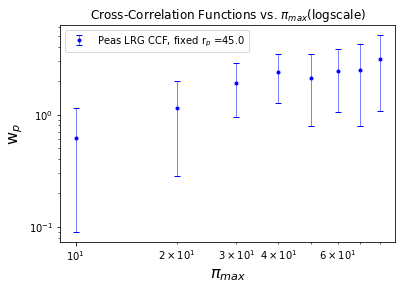

In [79]:
#n is the fixed r_p index
n = 10
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5,label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$(logscale)')

90.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

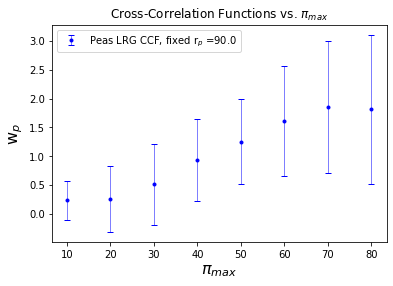

In [80]:
#n is the fixed r_p index
n = 13
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5,  label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

70.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

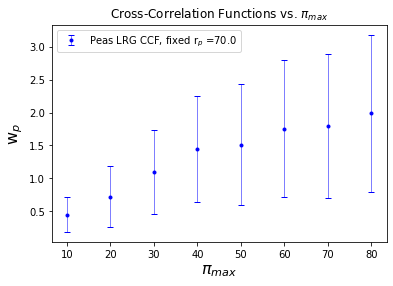

In [81]:
#n is the fixed r_p index
n = 12
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

55.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

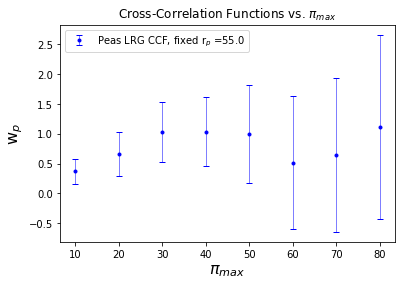

In [82]:
#n is the fixed r_p index
n = 11
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

45.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

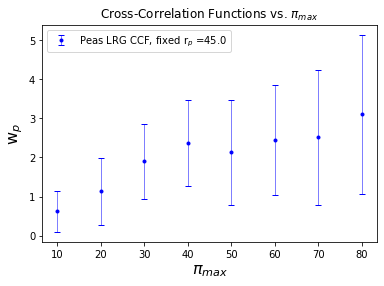

In [83]:
#n is the fixed r_p index
n = 10
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

35.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

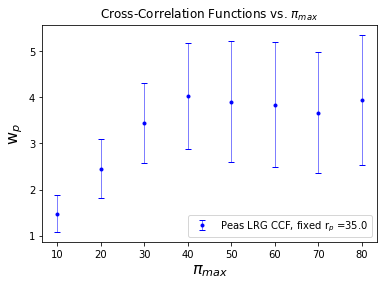

In [84]:
#n is the fixed r_p index
n = 9
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

25.0


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

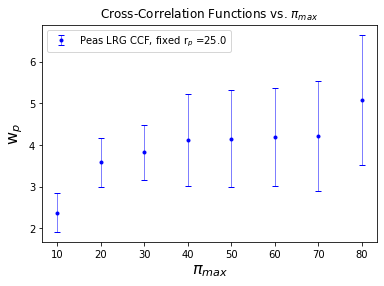

In [85]:
#n is the fixed r_p index
n = 8
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

17.5


Text(0.5, 1.0, 'Cross-Correlation Functions vs. $\\pi_{max}$')

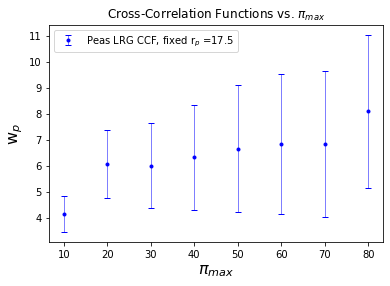

In [86]:
#n is the fixed r_p index
n = 7
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n] ])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')

90.0


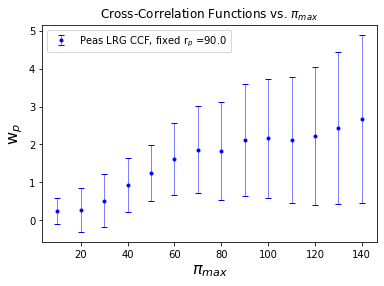

In [155]:
#n is the fixed r_p index
n = 13
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

70.0


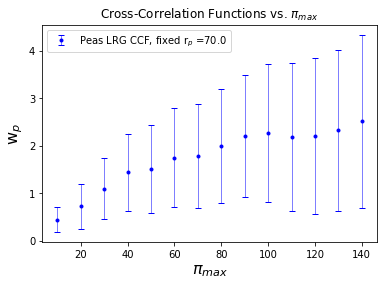

In [156]:
#n is the fixed r_p index
n = 12
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

55.0


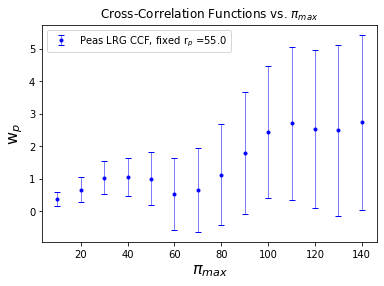

In [157]:
#n is the fixed r_p index
n = 11
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

45.0


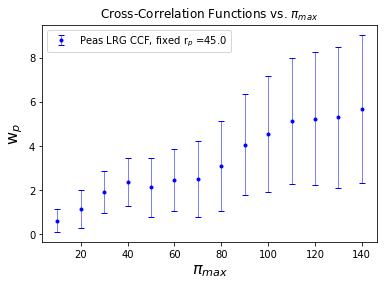

In [163]:
#n is the fixed r_p index
n = 10
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

35.0


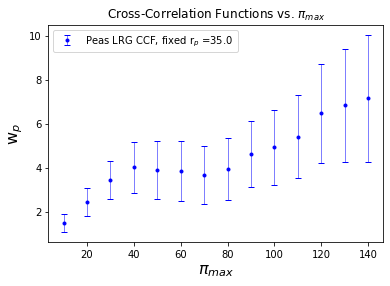

In [158]:
#n is the fixed r_p index
n = 9
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

25.0


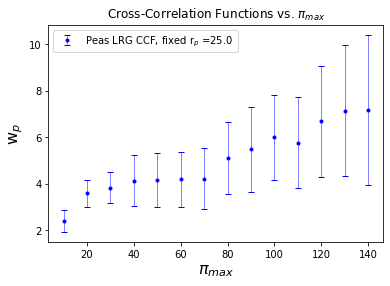

In [159]:
#n is the fixed r_p index
n = 8
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png

17.5


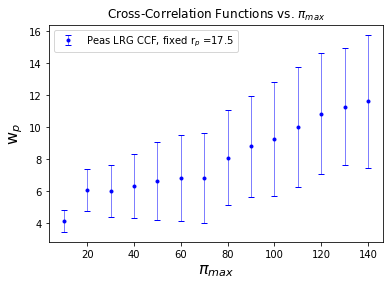

In [162]:
#n is the fixed r_p index
n = 7
r_p = rp_xc_Pjackpi70[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10[n], wp_xc_Pjackpi20[n], wp_xc_Pjackpi30[n], wp_xc_Pjackpi40[n], wp_xc_Pjackpi50[n], wp_xc_Pjackpi60[n], wp_xc_Pjackpi70[n], wp_xc_Pjackpi80[n], wp_xc_Pjackpi90[n], wp_xc_Pjackpi100[n], wp_xc_Pjackpi110[n], wp_xc_Pjackpi120[n], wp_xc_Pjackpi130[n], wp_xc_Pjackpi140[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10[n], wp_xc_err_Pjackpi20[n], wp_xc_err_Pjackpi30[n], wp_xc_err_Pjackpi40[n], wp_xc_err_Pjackpi50[n], wp_xc_err_Pjackpi60[n], wp_xc_err_Pjackpi70[n], wp_xc_err_Pjackpi80[n], wp_xc_err_Pjackpi90[n], wp_xc_err_Pjackpi100[n], wp_xc_err_Pjackpi110[n], wp_xc_err_Pjackpi120[n], wp_xc_err_Pjackpi130[n], wp_xc_err_Pjackpi140[n] ])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')

In [8]:
rzpea = np.load('../codes/output/rzpeas.npy')
LRG= Table.read('../codes/MainCatalogues/LRGzcat.fits')
LRGr=Table.read('../codes/MainCatalogues/LRGRandzcat.fits')

In [10]:
bins = np.array([.1,.5,1,3,6,8,10,15,20,30,40,50,60,80,100])
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 10
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi10LS,wp_xc_Pjackpi10LS,wp_xc_err_Pjackpi10LS,cov_xc_Pjackpi10LS = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='L')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/CCFResults/LandySzalay/rp_xc_Pjackpi10LS.npy', rp_xc_Pjackpi10LS)
np.save('output/CCFResults/LandySzalay/wp_xc_Pjackpi10LS.npy',wp_xc_Pjackpi10LS)
np.save('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi10LS.npy', wp_xc_err_Pjackpi10LS)
np.save('output/CCFResults/LandySzalay/cov_xc_Pjackpi10LS.npy',cov_xc_Pjackpi10LS)

2020-10-24 20:45:36


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.050 sec
Using AVX512 kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.007 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.986 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 

In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.921 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.097 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.102 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.969 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 23.260 secs
/data/home/mokyay/Research Files/Green-Peas/codes/clustering/clustering/error.py:204: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if cat==None:
/home/mokyay/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:3064: FutureWarning: elementwise == comparison 

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.160 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.165 secs
In gridl

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.131 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs
In gridl

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 416. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.992 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs
In gridl

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 446. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.161 secs
In gridl

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.187 secs
In gridl

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.094 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.172 secs
In gridl

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.093 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.163 secs
In gridl

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 451. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.185 secs
In gridl

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 440. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs
In gridl

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 466. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.093 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.165 secs
In gridl

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.108 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs
In gridl

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.175 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.188 secs
In gridl

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,10.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (38, 35, 11); avg_np = 418. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 57,52,11.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 57,52,11.  Time taken =   1.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs
In gridl

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 374. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.851 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.127 secs
In gridl

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 10); avg_np = 492. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,10.  Time taken =   1.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.160 secs
In gridl

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.137 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.174 secs
In gridl

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.163 secs
In gridl

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,34,10.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 443. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.127 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs
In gridl

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 421. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs
In gridl

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 464. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.117 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.173 secs
In gridl

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs
In gridl

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.030 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.116 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.170 secs
In gridl

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.031 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 427. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.025 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.153 secs
In gridl

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 448. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.071 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.184 secs
In gridl

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 39,35,11.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (39, 35, 11); avg_np = 471. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 58,52,11.  Time taken =   1.109 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.164 secs
In gridl

2020-10-24 21:35:31


 done. Time taken = 58.828 secs


In [11]:
bins = np.array([.1,.5,1,3,6,8,10,15,20,30,40,50,60,80,100])
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 60
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi60LS,wp_xc_Pjackpi60LS,wp_xc_err_Pjackpi60LS,cov_xc_Pjackpi60LS = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='L')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/CCFResults/LandySzalay/rp_xc_Pjackpi60LS.npy', rp_xc_Pjackpi60LS)
np.save('output/CCFResults/LandySzalay/wp_xc_Pjackpi60LS.npy',wp_xc_Pjackpi60LS)
np.save('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi60LS.npy', wp_xc_err_Pjackpi60LS)
np.save('output/CCFResults/LandySzalay/cov_xc_Pjackpi60LS.npy',cov_xc_Pjackpi60LS)

2020-10-24 22:39:08


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.655 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.434 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.035 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.043 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.060 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.063 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.693 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 56.140 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.021 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.387 secs
In gridlink_mo

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.364 secs
In gridlink_mo

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.044 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 701. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.950 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.323 secs
In gridlink_mo

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 752. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.987 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.343 secs
In gridlink_mo

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.397 secs
In gridlink_mo

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.380 secs
In gridlink_mo

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.403 secs
In gridlink_mo

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 761. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.978 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.360 secs
In gridlink_mo

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.048 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 742. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.949 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.334 secs
In gridlink_mo

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 785. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.358 secs
In gridlink_mo

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.377 secs
In gridlink_mo

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.364 secs
In gridlink_mo

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.049 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 687. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 49,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 49,45,9.  Time taken =   0.870 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.327 secs
In gridlink_mo

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.037 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 630. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.801 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.271 secs
In gridlink_mo

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 754. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.968 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.358 secs
In gridlink_mo

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.408 secs
In gridlink_mo

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.393 secs
In gridlink_mo

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 747. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.963 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.376 secs
In gridlink_mo

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 709. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.901 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.339 secs
In gridlink_mo

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.050 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 782. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.356 secs
In gridlink_mo

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.406 secs
In gridlink_mo

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.410 secs
In gridlink_mo

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.046 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 719. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.943 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.350 secs
In gridlink_mo

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.056 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.995 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.374 secs
In gridlink_mo

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,30,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (33, 30, 9); avg_np = 794. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 50,45,9.  Time taken =   1.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.401 secs
In gridlink_mo

2020-10-25 00:02:23


100% done. Time taken =     2 mins   21 secs


In [12]:
bins = np.array([.1,.5,1,3,6,8,10,15,20,30,40,50,60,80,100])
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 80
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi80LS,wp_xc_Pjackpi80LS,wp_xc_err_Pjackpi80LS,cov_xc_Pjackpi80LS = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='L')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/CCFResults/LandySzalay/rp_xc_Pjackpi80LS.npy', rp_xc_Pjackpi80LS)
np.save('output/CCFResults/LandySzalay/wp_xc_Pjackpi80LS.npy',wp_xc_Pjackpi80LS)
np.save('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi80LS.npy', wp_xc_err_Pjackpi80LS)
np.save('output/CCFResults/LandySzalay/cov_xc_Pjackpi80LS.npy',cov_xc_Pjackpi80LS)

2020-10-25 00:02:23


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.068 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.595 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.496 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.032 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.635 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.065 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.063 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.501 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    73 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.977 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.464 secs
In gridli

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.465 secs
In gridli

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.052 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 963. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.898 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.389 secs
In gridlink_mo

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.03e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.958 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.425 secs
In gridli

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.993 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.479 secs
In gridli

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.454 secs
In gridli

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.057 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.952 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.495 secs
In gridli

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.05e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.995 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.486 secs
In gridli

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.02e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.978 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.431 secs
In gridli

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.08e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.966 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.478 secs
In gridli

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.029 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.979 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.466 secs
In gridli

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.058 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.000 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.485 secs
In gridli

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 29,27,8.  Time taken =   0.026 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.055 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 944. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 45,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 45,41,8.  Time taken =   0.839 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.417 secs
In gridlink_mo

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.031 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 867. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.856 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.323 secs
In gridlink_mo

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.932 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.436 secs
In gridli

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.484 secs
In gridli

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.064 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.977 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.454 secs
In gridli

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.035 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.03e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.967 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.437 secs
In gridli

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.054 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 975. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.937 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.449 secs
In gridlink_mo

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.062 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.08e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.452 secs
In gridli

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.030 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.480 secs
In gridli

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.506 secs
In gridli

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.059 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 989. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.950 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.490 secs
In gridlink_mo

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.071 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.04e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.111 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.553 secs
In gridli

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.033 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.078 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,27,8.  Time taken =   0.008 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (30, 27, 8); avg_np = 1.09e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 46,41,8.  Time taken =   1.427 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.599 secs
In gridli

2020-10-25 01:48:30


100% done. Time taken =     3 mins   59 secs


In [13]:
bins = np.array([.1,.5,1,3,6,8,10,15,20,30,40,50,60,80,100])
## Run a clustering CROSS CORRELATION b/w the peas & LRGs w/ bootstrap - this is jackknife only
pimax = 70
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
## with errors? bootstrapped - idk
rp_xc_Pjackpi70LS,wp_xc_Pjackpi70LS,wp_xc_err_Pjackpi70LS,cov_xc_Pjackpi70LS = w.cross_wp(d1=peas, 
d2=LRG, r1=rzpea, r2=LRGr, bins=bins,pimax=pimax,m=5, estimator='L')
#,wp_arr_xc_Pjack

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
np.save('output/CCFResults/LandySzalay/rp_xc_Pjackpi70LS.npy', rp_xc_Pjackpi70LS)
np.save('output/CCFResults/LandySzalay/wp_xc_Pjackpi70LS.npy',wp_xc_Pjackpi70LS)
np.save('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi70LS.npy', wp_xc_err_Pjackpi70LS)
np.save('output/CCFResults/LandySzalay/cov_xc_Pjackpi70LS.npy',cov_xc_Pjackpi70LS)

2020-10-25 01:48:30


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.015 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   2.125 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.568 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.047 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.076 secs


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.106 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.107 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   2.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    88 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.070 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.205 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.517 secs
In gridlink_mo

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.076 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.006 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.343 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.526 secs
In gridlink_mo

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.007 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 748. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.288 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.427 secs
In gridlink_mo

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.063 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 802. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.467 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.497 secs
In gridlink_mo

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.075 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.419 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.511 secs
In gridlink_mo

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.072 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.076 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.294 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.520 secs
In gridlink_mo

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.032 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.225 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.543 secs
In gridlink_mo

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.005 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 28, 9); avg_np = 840. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.437 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.519 secs
In gridlink_mo

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.072 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 792. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.142 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.442 secs
In gridlink_mo

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.073 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 838. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.255 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.493 secs
In gridlink_mo

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.070 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.445 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.528 secs
In gridlink_mo

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.072 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.389 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.538 secs
In gridlink_mo

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,28,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,29,9.  Time taken =   0.009 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (31, 29, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 47,43,9.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 47,43,9.  Time taken =   1.146 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.467 secs
In gridlink_mo

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.051 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.004 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 672. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.361 secs
In gridlink_mo

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,8.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,8.  Time taken =   0.034 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.065 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,8.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 8); avg_np = 905. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,8.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,8.  Time taken =   1.292 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.532 secs
In gridlink_mo

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.070 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.210 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.491 secs
In gridlink_mo

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.071 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.267 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.545 secs
In gridlink_mo

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.068 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 28, 9); avg_np = 825. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.279 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.521 secs
In gridlink_mo

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 756. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.115 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.471 secs
In gridlink_mo

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.068 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 835. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.283 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.502 secs
In gridlink_mo

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.076 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.006 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.159 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.493 secs
In gridlink_mo

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.061 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.473 secs
In gridlink_mo

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.060 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.002 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 767. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.461 secs
In gridlink_mo

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.061 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.069 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.007 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 806. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.190 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.520 secs
In gridlink_mo

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,28,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.067 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,9.  Time taken =   0.003 sec
countpairs_mocks_double> gridlink seems inefficient. nmesh = (32, 29, 9); avg_np = 847. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 48,43,9.  Time taken =   1.272 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.516 secs
In gridlink_mo

2020-10-25 03:52:08


100% done. Time taken =     3 mins   16 secs


Text(0.5, 1.0, 'Cross-Correlation Functions - Peas vs LRG')

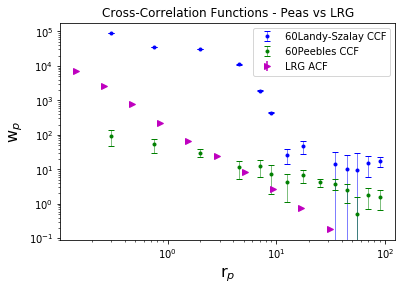

In [8]:
rp_LRGjack=np.load('output/CCFResults/rp_LRGjack.npy')
wp_p_LRGjack=np.load('output/CCFResults/wp_p_LRGjack.npy')
wp_p_err_LRGjack=np.load('output/CCFResults/wp_p_err_LRGjack.npy')
cov_LRGjack=np.load('output/CCFResults/cov_LRGjack.npy')


rp_xc_Pjackpi60 = np.load('output/CCFResults/rp_xc_Pjackpi60.npy')
wp_xc_Pjackpi60 = np.load('output/CCFResults/wp_xc_Pjackpi60.npy')
wp_xc_err_Pjackpi60 = np.load('output/CCFResults/wp_xc_err_Pjackpi60.npy')
cov_xc_Pjackpi60 = np.load('output/CCFResults/cov_xc_Pjackpi60.npy')

rp_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi60LS.npy')
wp_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi60LS.npy')
wp_xc_err_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi60LS.npy')
cov_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi60LS.npy')

plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp_xc_Pjackpi60LS,wp_xc_Pjackpi60LS,yerr=wp_xc_err_Pjackpi60LS,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='60Landy-Szalay CCF')
plt.errorbar(rp_xc_Pjackpi60,wp_xc_Pjackpi60,yerr=wp_xc_err_Pjackpi60,fmt='.',color='g', capsize = 3, elinewidth = 0.5, label='60Peebles CCF')
plt.errorbar(rp_LRGjack,wp_p_LRGjack/rp_LRGjack,yerr=wp_p_err_LRGjack/rp_LRGjack,fmt='>',color='m',label='LRG ACF')
#plt.errorbar(rp_xc_Pjackpi10LS,wp_xc_Pjackpi10LS,yerr=wp_xc_err_Pjackpi10LS,fmt='.',color='r', capsize = 3, elinewidth = 0.5, label='10Landy-Szalay CCF')
#plt.errorbar(rp_xc_Pjackpi10,wp_xc_Pjackpi10,yerr=wp_xc_err_Pjackpi10,fmt='.',color='y', capsize = 3, elinewidth = 0.5, label='10Peebles CCF')
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions - Peas vs LRG')

In [26]:
rp_xc_Pjackpi10LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi10LS.npy')
wp_xc_Pjackpi10LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi10LS.npy')
wp_xc_err_Pjackpi10LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi10LS.npy')
cov_xc_Pjackpi10LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi10LS.npy')

rp_xc_Pjackpi20LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi20LS.npy')
wp_xc_Pjackpi20LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi20LS.npy')
wp_xc_err_Pjackpi20LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi20LS.npy')
cov_xc_Pjackpi20LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi20LS.npy')

rp_xc_Pjackpi30LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi30LS.npy')
wp_xc_Pjackpi30LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi30LS.npy')
wp_xc_err_Pjackpi30LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi30LS.npy')
cov_xc_Pjackpi30LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi30LS.npy')

rp_xc_Pjackpi40LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi40LS.npy')
wp_xc_Pjackpi40LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi40LS.npy')
wp_xc_err_Pjackpi40LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi40LS.npy')
cov_xc_Pjackpi40LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi40LS.npy')

rp_xc_Pjackpi50LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi50LS.npy')
wp_xc_Pjackpi50LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi50LS.npy')
wp_xc_err_Pjackpi50LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi50LS.npy')
cov_xc_Pjackpi50LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi50LS.npy')

rp_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi60LS.npy')
wp_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi60LS.npy')
wp_xc_err_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi60LS.npy')
cov_xc_Pjackpi60LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi60LS.npy')

rp_xc_Pjackpi70LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi70LS.npy')
wp_xc_Pjackpi70LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi70LS.npy')
wp_xc_err_Pjackpi70LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi70LS.npy')
cov_xc_Pjackpi70LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi70LS.npy')

rp_xc_Pjackpi80LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi80LS.npy')
wp_xc_Pjackpi80LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi80LS.npy')
wp_xc_err_Pjackpi80LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi80LS.npy')
cov_xc_Pjackpi80LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi80LS.npy')

rp_xc_Pjackpi90LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi90LS.npy')
wp_xc_Pjackpi90LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi90LS.npy')
wp_xc_err_Pjackpi90LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi90LS.npy')
cov_xc_Pjackpi90LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi90LS.npy')

rp_xc_Pjackpi100LS = np.load('output/CCFResults/LandySzalay/rp_xc_Pjackpi100LS.npy')
wp_xc_Pjackpi100LS = np.load('output/CCFResults/LandySzalay/wp_xc_Pjackpi100LS.npy')
wp_xc_err_Pjackpi100LS = np.load('output/CCFResults/LandySzalay/wp_xc_err_Pjackpi100LS.npy')
cov_xc_Pjackpi100LS = np.load('output/CCFResults/LandySzalay/cov_xc_Pjackpi100LS.npy')

In [16]:
rp_xc_Pjackpi70LS

array([ 0.3 ,  0.75,  2.  ,  4.5 ,  7.  ,  9.  , 12.5 , 17.5 , 25.  ,
       35.  , 45.  , 55.  , 70.  , 90.  ])

90.0


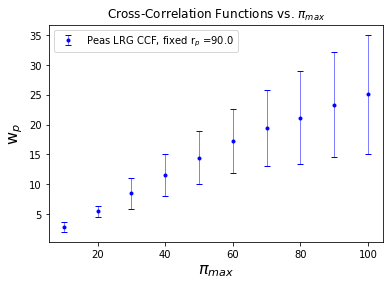

In [55]:
#n is the fixed r_p index
n = 13
r_p = rp_xc_Pjackpi70LS[n]
print(r_p)
#x-axis
pimaxArr = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
#y-axis
rp_n_Wp = np.array([wp_xc_Pjackpi10LS[n],wp_xc_Pjackpi20LS[n], wp_xc_Pjackpi30LS[n], wp_xc_Pjackpi40LS[n], wp_xc_Pjackpi50LS[n], wp_xc_Pjackpi60LS[n], wp_xc_Pjackpi70LS[n], wp_xc_Pjackpi80LS[n], wp_xc_Pjackpi90LS[n], wp_xc_Pjackpi100LS[n]])
#y-axis-err
rp_n_Wp_err = np.array([wp_xc_err_Pjackpi10LS[n], wp_xc_err_Pjackpi10LS[n], wp_xc_err_Pjackpi30LS[n], wp_xc_err_Pjackpi40LS[n], wp_xc_err_Pjackpi50LS[n], wp_xc_err_Pjackpi60LS[n], wp_xc_err_Pjackpi70LS[n], wp_xc_err_Pjackpi80LS[n], wp_xc_err_Pjackpi90LS[n], wp_xc_err_Pjackpi100LS[n]])
#plt.yscale("log")
#plt.xscale("log")
plt.errorbar(pimaxArr,rp_n_Wp,yerr=rp_n_Wp_err,fmt='.',color='b', capsize = 3, elinewidth = 0.5, label='Peas LRG CCF, fixed r$_p$ ='+ str(r_p))
#plt.errorbar(label='r$_p$ = ' + str(r_p))
##plt.errorbar(rp_LRGboot,wp_p_LRGboot,yerr=wp_p_err_LRGboot,fmt='.',color='r',label='LRG ACF Boostrap')
plt.legend(frameon=True,numpoints=1)
plt.xlabel('$\pi_{max}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Cross-Correlation Functions vs. $\pi_{max}$')
plt.savefig('output/PlotsGraphs/LS/peaslrgccf_wPvsPi_fixrP_'+ str(r_p)+'.png')